<a href="https://colab.research.google.com/github/kwanderer/Autonomas-sistemas-un-roboti/blob/main/RF_Klasifikacija_nestim50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Laika virknēm (*Time series*) datu sadala gabalos - apakšvirknēs. Līdzīgi kā k-pārklājumu gadījumā;
*   K-Pārklājumiem:
  * Jo lielāks K, jo objektīvāks modelis, bet lielāka variance starp dažādiem modeļiem;
  * Jo mazāks K, jo lielāka iespēja iegūt vairākus vājus modeļus;
* Nejauša izlase jāveic bez aizvietošanas. Aizvietošana ir nejauša izlase no apmācības kopas, kurā **var dublēties ieraksti**
* Nejauša izlase ar aizvietošanu ir *bootstrap* sāknētājs: 
    Mazina kļūdas ietekmes novērtējumu - tas ir optimistiskāks;

## Datu iegūšana

In [ ]:
from sklearn import linear_model  #pip install sklearn - loti plasa masinapmacibas biblioteka
from sklearn.linear_model import LinearRegression  
import csv          #pip install csv - darbam ar CSV datu kopam
import requests     #pip install requests  - vienkarsakam darbam ar tiessaistes CSV datu kopam tiessaistes
import numpy as np  #pip inall numpy - darbam ar masiviem un skaitliskiem datiem
import pandas as pd #pip install pandas - darbam ar datu kopam

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/data_multiclass")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv("combined_multiclass_csv.csv")

In [ ]:
print(df.info())              # Pārliecināmies, ka kolonnas nesaturs tukšas vērtības

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000000 entries, 0 to 29999999
Data columns (total 9 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   tachometer                     float64
 1   und-accelerometer-axial        float64
 2   und-accelerometer-radial       float64
 3   und-accelerometer-tangential   float64
 4   over-accelerometer-axial       float64
 5   over-accelerometer-radial      float64
 6   over-accelerometer-tangential  float64
 7   microphone                     float64
 8   Class                          int64  
dtypes: float64(8), int64(1)
memory usage: 2.0 GB
None


In [ ]:
df[df.columns] = df[df.columns].apply(pd.to_numeric)  # Visas l\kolonnas pārvēršam par skaitliskiem tipiem, jo redzējām, ka tie ir skaitļi
print("\n", df.describe(include=['number']))          # Attēlojam kopas statistiku
print(df.info())                                      # vēlreiz izdrukājam kopsavilkumu par datu kopu un kvalitāti


          tachometer  und-accelerometer-axial  und-accelerometer-radial  \
count  3.000000e+07             3.000000e+07              3.000000e+07   
mean   1.414637e-04             1.315306e-02             -2.493558e-04   
std    1.646523e+00             1.004443e+00              4.971494e-01   
min   -1.425000e+00            -1.906400e+01             -7.292000e+00   
25%   -6.456600e-01            -7.622600e-01             -3.273000e-01   
50%   -5.953200e-01             1.350000e-01              1.287600e-02   
75%   -5.039000e-01             8.976500e-01              3.313300e-01   
max    5.114900e+00             2.165400e+00              3.193800e+00   

       und-accelerometer-tangential  over-accelerometer-axial  \
count                  3.000000e+07              3.000000e+07   
mean                   4.011626e-04              1.089396e-02   
std                    1.421448e-01              5.507483e-01   
min                   -7.551200e-01             -8.488600e+00   
25%   

In [ ]:
# pārbaudam vai visas vērtības ir vienā vērtību skalā. 
print(df[:10].to_markdown()) 

|    |   tachometer |   und-accelerometer-axial |   und-accelerometer-radial |   und-accelerometer-tangential |   over-accelerometer-axial |   over-accelerometer-radial |   over-accelerometer-tangential |   microphone |   Class |
|---:|-------------:|--------------------------:|---------------------------:|-------------------------------:|---------------------------:|----------------------------:|--------------------------------:|-------------:|--------:|
|  0 |     -0.5964  |                  1.6569   |                   0.20359  |                      0.048174  |                   -0.18477 |                   -0.021301 |                        -0.18447 |   -0.017205  |       7 |
|  1 |     -0.52322 |                 -0.28902  |                  -0.3174   |                     -0.0014495 |                   -0.19779 |                   -0.023694 |                        -0.28712 |   -0.018203  |       7 |
|  2 |     -0.5532  |                  1.6477   |                   0.41715  |  

## Datu sagatavošana

Pirmais, kas darāms pēc datu iegūšanas un apskates, jāveic datu kopas sagatavošana

In [ ]:
from sklearn.model_selection import train_test_split

training_frac = 0.8

# iegūstam klases, kas tiks klasificētas piemērā
Classes = df['Class'].unique()

# unikālās klases
print("Klašu vērtības", Classes,'\n')

#Klašu kodēšana
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['Class'])
print(le.classes_)

Klašu vērtības [7 6 5 4 3 2 1 0] 

[0 1 2 3 4 5 6 7]


In [ ]:
# atlasām tikai faktoru kolonnas, klases kolonna nav vajadzīga
Sample = df[["tachometer", "und-accelerometer-axial", "und-accelerometer-radial", "und-accelerometer-tangential", "over-accelerometer-axial", "over-accelerometer-radial", "over-accelerometer-tangential", "microphone"]].to_numpy()

#atlasām klases kolonnu
y = le.transform(df['Class'])
print(y)

# tiek veikta datu kopas sadalīšana testa un apmācības kopā, izmantojot nejaušu sadalījumu ar attecību 80 : 20
X_train, X_test, y_train, y_test = train_test_split(Sample, y, test_size=1.0 - training_frac, random_state=42)

print('Done .........')

[7 7 7 ... 0 0 0]
Done .........


## *Random Forest* modeļa izveide

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=10)          # Izveidojam klasifikatoru ar 10 kokiem un maks. dziļumu 5
rf.fit(X_train, y_train)                                                             # Modeļa apmācība

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=10)

Faktoru rangi:
4. faktors over-accelerometer-axial (0.525940)
5. faktors over-accelerometer-radial (0.148934)
6. faktors over-accelerometer-tangential (0.141307)
3. faktors und-accelerometer-tangential (0.106068)
2. faktors und-accelerometer-radial (0.065601)
1. faktors und-accelerometer-axial (0.009491)
7. faktors microphone (0.001536)
0. faktors tachometer (0.001122)


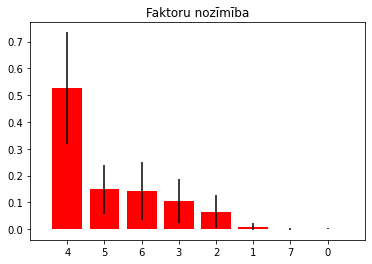

In [ ]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_         # iegūstam faktoru nozīmības rādītājus
indices = np.argsort(importances)[::-1]       # iegūstam faktoru indeksus (kārtas numurus)
                                              # Definējam faktoruu nosaukums skaistākai izvadei
FeatureNames = ["tachometer", "und-accelerometer-axial", "und-accelerometer-radial", "und-accelerometer-tangential", "over-accelerometer-axial", "over-accelerometer-radial", "over-accelerometer-tangential", "microphone"]

#   Izvadam faktoru rangus
print("Faktoru rangi:")
for f in range(X_train.shape[1]):             # Katrā iterācijā apskatāmkonkrēta faktora rangu
                                              # Izvadām faktorus
    #print("%d. faktors %s (%f)" % (f + 1, FeatureNames[indices[f]], importances[indices[f]]))
    print("%d. faktors %s (%f)" % (indices[f], FeatureNames[indices[f]], importances[indices[f]]))

# Aprēķinām faktoru nozīmības standartnovirzes izvadei
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Izveidojam attēlu
plt.figure()
plt.title("Faktoru nozīmība")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Rezultātu interpretēšana

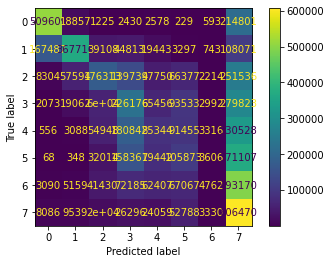

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm,display_labels=le.classes_).plot()

### Dažādas formālas metrikas

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print("Kopējā vidējā precizitāte :                         ",accuracy_score(y_test, y_pred))

#F1 metrika: F1 = 2 * (precision * sensitivity) / (precision + sensitivity)
# 1 - vislabākais gadījums, 0 - vissliktākais

print("Kopējā vidējā F1 vērtība pa visām klasēm :           ",f1_score(y_test, y_pred, average='macro'))
print("Kopējā vidējā F1 vērtība ņemot vērā klašu balansu : ",f1_score(y_test, y_pred, average='weighted'))

Kopējā vidējā precizitāte :                          0.34704383333333333
Kopējā vidējā F1 vērtība pa visām klasēm :            0.32172010378043336
Kopējā vidējā F1 vērtība ņemot vērā klašu balansu :  0.32179652403260195


Confusion matrix, without normalization
[[509609  18857   1225   2430   2578    229    593 214801]
 [167487 367716  39108  44813  19443   3297    743 108071]
 [  8304  57594 176313 139739  47750  66377   2214 251536]
 [  2073  19062  59663 226176  65456  93533   2992 279823]
 [   556   3088  54948 180842  85344  91455   3316 330528]
 [    68    348  32014 158361  79442 105873   3606 371107]
 [  3090   5159  41430  72185  62407  67067   4762 493170]
 [  8086   9539  19661  26296  24059  52788   3330 606470]]
Normalized confusion matrix
[[6.79e-01 2.51e-02 1.63e-03 3.24e-03 3.44e-03 3.05e-04 7.90e-04 2.86e-01]
 [2.23e-01 4.90e-01 5.21e-02 5.97e-02 2.59e-02 4.39e-03 9.90e-04 1.44e-01]
 [1.11e-02 7.68e-02 2.35e-01 1.86e-01 6.37e-02 8.85e-02 2.95e-03 3.35e-01]
 [2.77e-03 2.55e-02 7.97e-02 3.02e-01 8.74e-02 1.25e-01 4.00e-03 3.74e-01]
 [7.41e-04 4.12e-03 7.33e-02 2.41e-01 1.14e-01 1.22e-01 4.42e-03 4.41e-01]
 [9.06e-05 4.63e-04 4.26e-02 2.11e-01 1.06e-01 1.41e-01 4.80e-03 4.94e-01]
 [4.12e-0

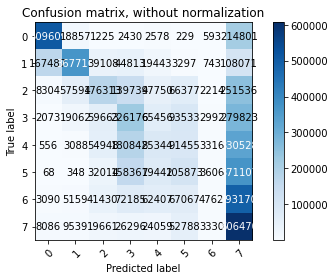

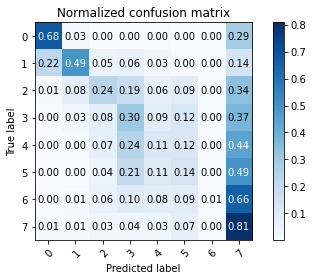

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = np.array(['0', '1', '2', '3', '4', '5', '6', '7'])

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_test, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()